In [20]:
#可视化中间层
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import glob
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

conv1
layer1.0.conv3
layer1.1.conv3
layer1.2.conv3
layer2.0.conv3
layer2.1.conv3
layer2.2.conv3
layer3.0.conv3
layer3.1.conv3
layer3.2.conv3
layer3.3.conv3
layer3.4.conv3
layer3.5.conv3
layer4.0.conv3
layer4.1.conv3
layer4.2.conv3
3


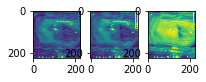

24


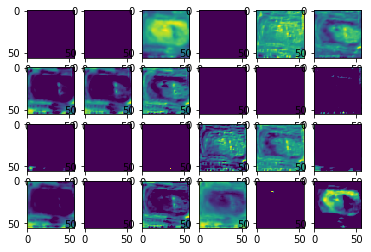

24


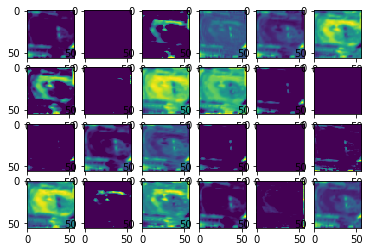

24


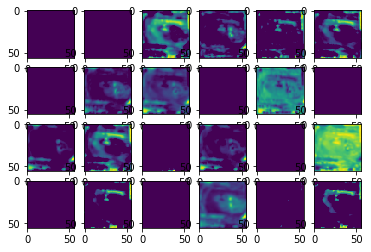

24


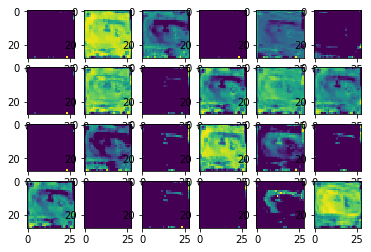

24


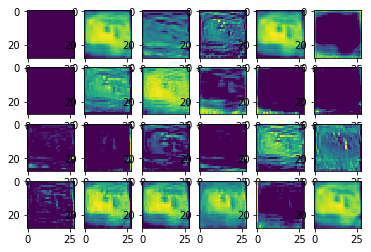

24


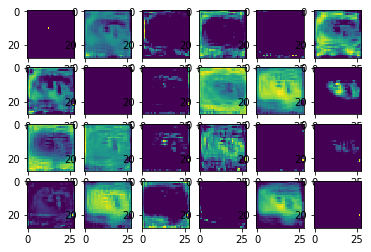

24


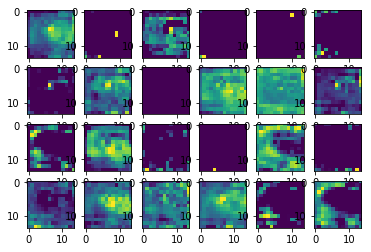

24


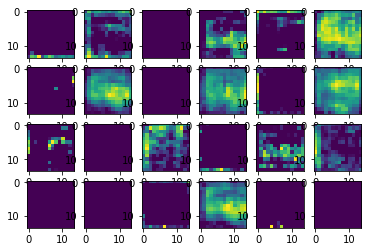

24


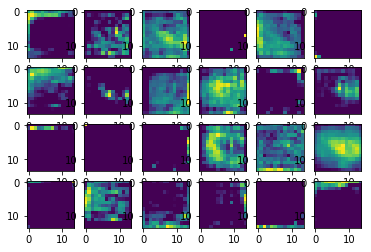

24


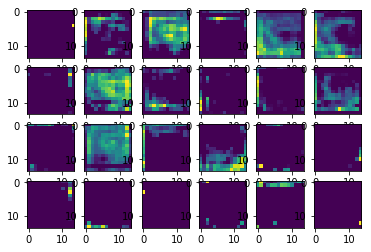

24


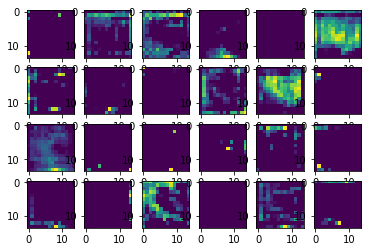

24


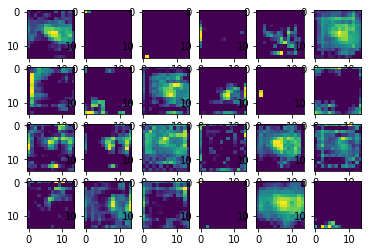

24


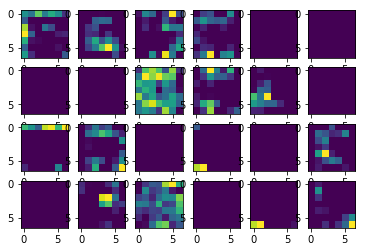

24


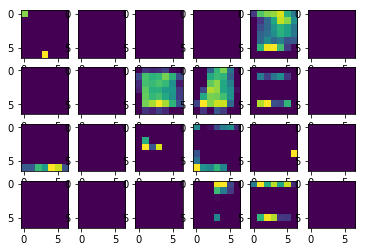

24


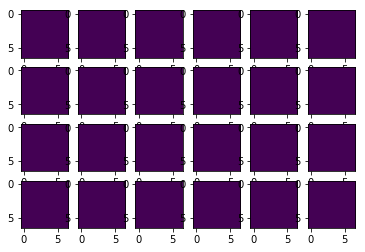

In [26]:
def viz(module,input):
    x = input[0][0]
    #最多显示4张图
   # print('input:',input)
    min_num = np.minimum(24, x.size()[0])
    print(min_num)
    for i in range(min_num):
        plt.subplot(4, 6, i+1)
        plt.imshow(x[i].cpu())
    now=time.strftime("%Y-%m-%d-%H_%M_%S",time.localtime(time.time()))
    filename=os.path.join('./feature',now+'.jpg')
    plt.savefig(filename)
    plt.show()
def main():
    names=['conv1','layer1.0.conv3','layer1.1.conv3','layer1.2.conv3','layer2.0.conv3','layer2.1.conv3','layer2.2.conv3',
          'layer3.0.conv3','layer3.1.conv3','layer3.2.conv3','layer3.3.conv3','layer3.4.conv3','layer3.5.conv3',
          'layer4.0.conv3','layer4.1.conv3','layer4.2.conv3']
    t = transforms.Compose([transforms.ToPILImage(),
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.5941, 0.3818, 0.3370],
                                                 std=[0.1508 ,0.1404, 0.1222])
                            ])

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    load_path='/home/are/data_cervical/pytorch_running/third/resnet50/epoch80/resnet50.pth'
    model=torch.load(load_path)
    model = model.to(device)
    for name, m in model.named_modules():
        # if not isinstance(m, torch.nn.ModuleList) and \
        #         not isinstance(m, torch.nn.Sequential) and \
        #         type(m) in torch.nn.__dict__.values():
        # 这里只对卷积层的feature map进行显示
        #print(name)
        #if isinstance(m, torch.nn.Conv2d):
        if name in names:
            print(name)
           
            m.register_forward_pre_hook(viz)
    img = cv2.imread('/home/are/data_cervical/pytorch_running/3_data/caijian2/train/THREE/3_100.jpg')
    img = t(img).unsqueeze(0).to(device)
    with torch.no_grad():
        model(img)

if __name__ == '__main__':
    main()
    


In [ ]:
def preprocess_image(cv2im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (Pytorch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        cv2im = cv2.resize(cv2im, (224, 224))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


class FeatureVisualization():
    def __init__(self,img_path,selected_layer):
        self.img_path=img_path
        self.selected_layer=selected_layer
        self.pretrained_model = models.vgg16(pretrained=True).features

    def process_image(self):
        img=cv2.imread(self.img_path)
        img=preprocess_image(img)
        return img

    def get_feature(self):
        # input = Variable(torch.randn(1, 3, 224, 224))
        input=self.process_image()
        print(input.shape)
        x=input
        for index,layer in enumerate(self.pretrained_model):
            x=layer(x)
            if (index == self.selected_layer):
                return x

    def get_single_feature(self):
        features=self.get_feature()
        print(features.shape)

        feature=features[:,0,:,:]
        print(feature.shape)

        feature=feature.view(feature.shape[1],feature.shape[2])
        print(feature.shape)

        return feature

    def save_feature_to_img(self):
        #to numpy
        feature=self.get_single_feature()
        feature=feature.data.numpy()

        #use sigmod to [0,1]
        feature= 1.0/(1+np.exp(-1*feature))

        # to [0,255]
        feature=np.round(feature*255)
        print(feature[0])

        cv2.imwrite('./img.jpg',feature)